# Model QC Notebook

<img style="float:right;" src="https://id.dewberry.com/clients/Templates/DewberryLogo_RGB.png" width=150px>

### Description
Read data from ADCIRC input files, verify attribute parametrization is appropriate.

---

#### - Requirements
  1. Dewberry ADCIRC Python Library (Python 3.6)
  2. ADCIRC Input Files
  
#### - Usage:
  1. Import Libraries & Assign Paths
  2. Read in data from files, verify options and inputs:
   -  fort.13 (Nodal Attributes)
   - fort.14 (Mesh)
   -  fort.15 (Control File)
  3. Add comments/Request feedback
  4. Write all data from runfiles into a single netCDF file.
  5. Save Report
  
 ---

### 1. Import Libraries, Assign Paths, & Variables

In [1]:
import matplotlib.pyplot as plt
from adcirc import adcirc
import os
import pandas as pd
import netCDF4 as nc4
from datetime import datetime

In [3]:
#  Reviewer Name
qc_staff = 'Tyler Miesse'

root_dir = r'C:\Users\tmiesse\Work\climate_grib'
f13,f14,f15 = 'fort.13', 'fort.14' ,'fort.15'
fort13 = adcirc(root_dir,f13)
fort14 = adcirc(root_dir,f14)
fort15 = adcirc(root_dir,f15)

### 2. Read in data: fort.13 (Nodal Attributes)

List all attributes in the file & liste default values.

In [3]:
attr = fort13.attributes()
attr

,Parameter
0,mannings_n_at_sea_floor
1,primitive_weighting_in_continuity_equation
2,sea_surface_height_above_geoid
3,surface_canopy_coefficient
4,surface_directional_effective_roughness_length


---

#### <font color='blue'>QC Comments (8-1-2018)</font> 


Why are we not using surface_submergence_state? 

---

#### <font color='blue'>QC Response</font> 

---


#### Populate table with nodes that do not have the default parameter

In [4]:
table13 = fort13.read_fort13(attr)
table = pd.DataFrame.copy(table13)
table = adcirc.seperate_13(table)
table.head(2)

,sea_surface,manningsnodes,manningsdata,primitivenodes,primitivedata,surfacenodes,surfacedata,surfacedir_nodes,e,ene,ne,n,nw,wnw,w,wsw,sw,s,se,ese
0,NaN,1,2.0000000E-02,99630,0.020000,2,0,1,0.338714,0.342190,0.290161,0.381304,0.312560,0.349219,0.430571,0.304738,0.339980,0.177443,0.280711,0.292807
1,NaN,2,0.1000000,99631,0.020000,3,0,2,0.317080,0.319580,0.260337,0.416283,0.343137,0.408794,0.393798,0.371340,0.341123,0.227933,0.328570,0.326146


### fort.14 (Mesh)


In [5]:
table14 = fort14.read_fort14()
table14.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)
table14.head(2)

,node_id,lon,lat,value
0,1,-76.9454281377,39.0026000108,-39.4576339722
1,2,-76.9465507379,38.9968142640,-40.4124717712


### fort.15 (Control File)

In [3]:
table15 = fort15.read_fort15()
table15.head()

,30 CHARACTER ALPHANUM RUN DESCRIPTION,20 CHARACTER ALPANUMERIC RUN IDENTIFICATION,NFOVER,NABOUT,NSCREEN,IHOT,ICS,IM,NOLIBF,NOLIFA,...,"Wind Energy stations, last station","NOUTGE,TOUTSGE,TOUTFGE,NSPOOLGE : GLOBAL ELEV OUTPUT (UNIT 63)","NOUTGV,TOUTSGV,TOUTFGV,NSPOOLGV : GLOBAL VEL OUTPUT (UNIT 64)",NHARF,HAFNAM,"FREQUENCY, NODAL FACTOR, EQUILIBRIUM ARGUMENT (DEG)","THAS, THAF, NHAINC,FMV","NHASE,NHASV,NHAGE,NHAGV","NHSTAR,NHSINC","ITITER,ISLDIA,CONVCR,ITMAX"
0,nc_inundation,EqTides,1,1,100,0,2,111122,1,2,...,-75.59336 35.40026,-5 5 31 3600,-5 5 31 3600,35,STEADY,0.000000000000000 1.0 0.0,7 31 900 0.0000000,1 1 1 1,5 21600,0 0 1e-10 25


---
#### <font color='blue'>QC Comments: (date if applicable)</font> 
---

#### <font color='blue'>QC Response</font>
---

### Initialize netcdf & add data from current run files.

In [11]:
adcirc.initnc4(root_dir,table14)
manning = table[['manningsnodes','manningsdata']]
table_mann = table14.merge(manning, left_on='node_id',right_on='manningsnodes')
primitive = table[['primitivenodes','primitivedata']]
table_primitive = table14.merge(primitive, left_on='node_id',right_on='primitivenodes')
#surf = table[['surfacenodes','surfacedata']]
#table_surf = table14.merge(surf, left_on='node_id',right_on='surfacenodes')
surface_dir = table[['surfacedir_nodes','e','ene','ne','n','nw','wnw','w','wsw','sw','s','se','ese']]
table_surf_dir = table14.merge(surface_dir, left_on='node_id',right_on='surfacedir_nodes')
#average = table[['averagenodes','averagedata']]
#table_ave = table14.merge(average, left_on='node_id',right_on='averagenodes')
#wave = table[['wavenodes','wavedata']]
#table_waves = table14.merge(wave, left_on='node_id',right_on='wavenodes')
# convert tables to netcdf file
surf = 1
lon, lat = 'lon','lat'
adcirc.add_attribute2nc4(root_dir,table_mann,attr)
adcirc.add_attribute2nc4(root_dir,table_surf_dir,attr,lon,lat,surf)
#adcirc.add_attribute2nc4(root_dir,table_surf,attr)
#adcirc.add_attribute2nc4(root_dir,table_waves,attr)
adcirc.add_attribute2nc4(root_dir,table_primitive,attr)
#adcirc.add_attribute2nc4(root_dir,table_ave,attr)

## Plot Attributed nodes for all parameters 
*Customize Bounding boxes for each parameter as needed*

#### Mannings' n within the study area
- Showing the friction coefficients on the land

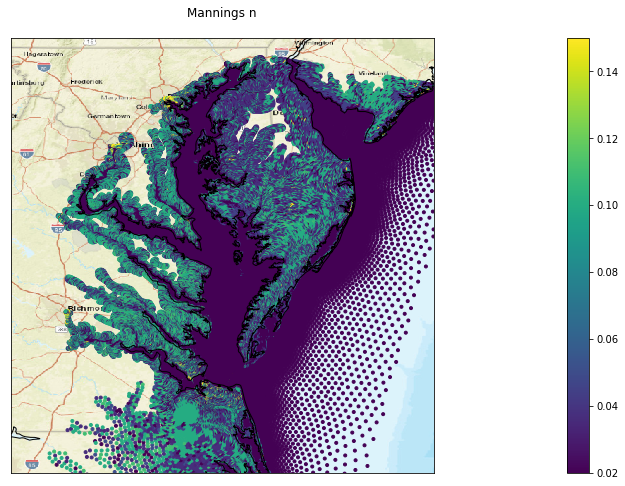

In [14]:
nc = nc4.Dataset(os.path.join(root_dir,'input_fort.nc'),'r')
grp = nc.groups['mannings_n_at_sea_floor']
lat1,lat2 = 36.2, 39.8
lon1,lon2 = -77.9, -74.4
title = 'Mannings n'
fig,ax=plt.subplots(figsize=(48,8))
adcirc.attr_plot(grp,title,ax,lat1,lat2,lon1,lon2)

---
#### <font color='blue'>QC Comments: (date if applicable)</font> 
---

#### <font color='blue'>QC Response</font>
---

#### Surface Canopy Coefficient in the Study Area
- Turns off the wind stress in heavily forested areas that have been flooded (marshes, swamps, etc). The canopy shields the water from the effect of the wind.
- Zero if the wind stress should be zero because of a canopy. One otherwise.

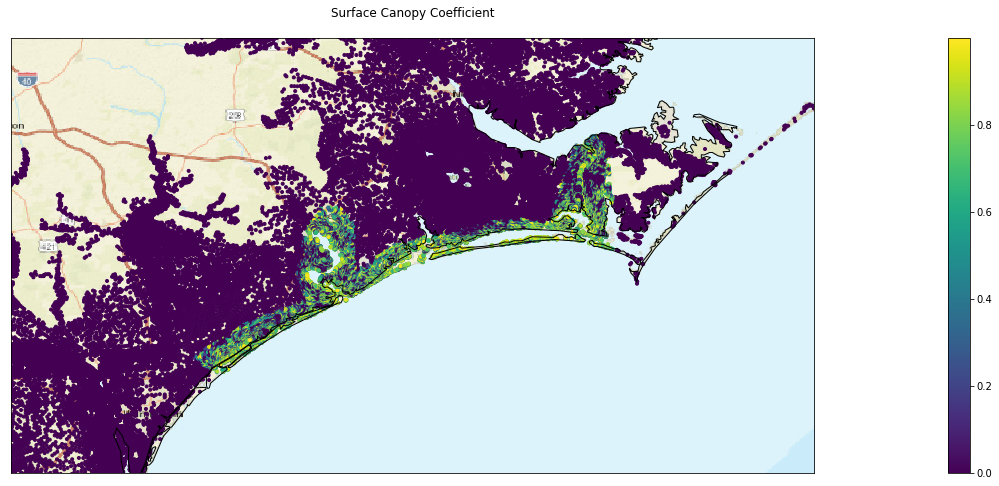

In [10]:
nc = nc4.Dataset(os.path.join(root_dir,'input_fort.nc'),'r')
grp = nc.groups['surface_canopy_coefficient']
lat1,lat2 = 36.68, 39.453
lon1,lon2 = -77.5, -73.79
title = 'Surface Canopy Coefficient'
fig,ax=plt.subplots(figsize=(48,8))
adcirc.attr_plot(grp,title,ax,lat1,lat2,lon1,lon2)

---
#### <font color='blue'>QC Comments: (8-1-2018)</font> 
Canopy should be 0 or 1, is this a plotting issue? please verify.

---
#### <font color='blue'>QC Response</font>
---

#### Average Horizontal Eddy Viscosity in Sea Water in the Study Area
- Spatially constant horizontal eddy diffusivity.

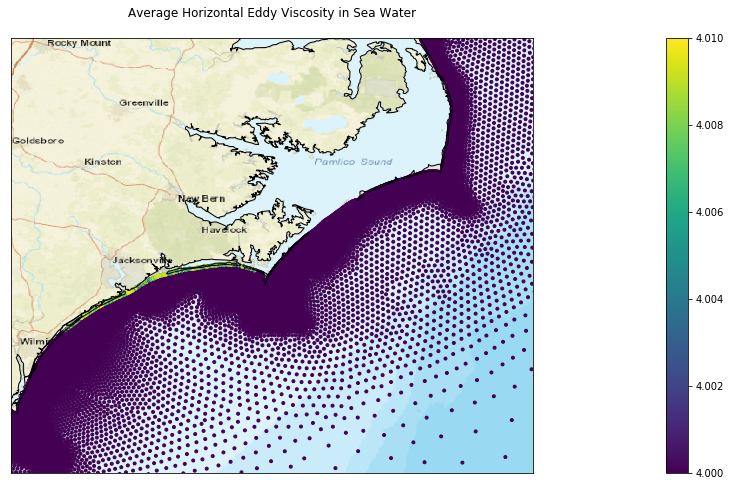

In [11]:
nc = nc4.Dataset(os.path.join(root_dir,'input_fort.nc'),'r')
grp = nc.groups['average_horizontal_eddy_viscosity_in_sea_water_wrt_depth']
lat1,lat2 = 33.5, 36
lon1,lon2 = -78, -75
data = 'Data'
title = 'Average Horizontal Eddy Viscosity in Sea Water'
fig,ax=plt.subplots(figsize=(48,8))
adcirc.attr_plot(grp,title,ax,lat1,lat2,lon1,lon2)

---
#### <font color='blue'>QC Comments: (date if applicable)</font> 
---

#### <font color='blue'>QC Response</font>
---

#### Primitive Weighting in Continuity Equation in the Study Area
- Weighting factor that weights the relative contribution of the primitive and wave portions of the GWCE.

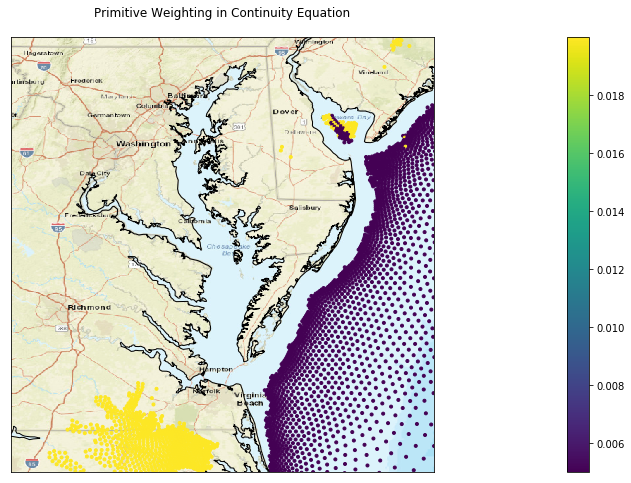

In [15]:
nc = nc4.Dataset(os.path.join(root_dir,'input_fort.nc'),'r')
grp = nc.groups['primitive_weighting_in_continuity_equation']
lat1,lat2 = 36.2, 39.8
lon1,lon2 = -77.9, -74.4
title = 'Primitive Weighting in Continuity Equation'
fig,ax=plt.subplots(figsize=(48,8))
adcirc.attr_plot(grp,title,ax,lat1,lat2,lon1,lon2)

---
#### <font color='blue'>QC Comments: (date if applicable)</font> 
---

#### <font color='blue'>QC Response</font>
---

#### Wave Refraction in Swan in the Study Area
- Turn wave refraction on or off in the SWAN calculations during a coupled ADCIRC+SWAN run.

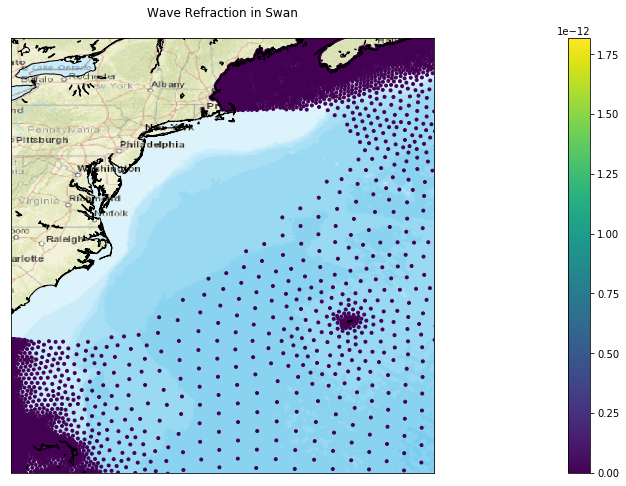

In [8]:
nc = nc4.Dataset(os.path.join(root_dir,'input_fort.nc'),'r')
grp = nc.groups['wave_refraction_in_swan']
lat1,lat2 = 25.5, 45
lon1,lon2 = -80, -61
title = 'Wave Refraction in Swan'
fig,ax=plt.subplots(figsize=(48,8))
adcirc.attr_plot(grp,title,ax,lat1,lat2,lon1,lon2)

---
#### <font color='blue'>QC Comments: (date if applicable)</font> 
---

#### <font color='blue'>QC Response</font>
---

#### Surface Directional Effective Roughness Length All Directions Plot
- A measure of the “roughness” of the land that can impede wind flow and reduce the surface stress that the wind applies. The ocean would be considered very smooth, and skyscrapers would be considered very rough. This attribute is directional, and the twelve values represent the roughness lengths “seen” by winds blowing from twelve different compass directions at each node.
- The orientation of the twelve values follows the trigonometric convention, that is, zero degrees represents due east, and the values proceed counter clockwise. In other words, the first value at a node is applied to winds blowing from west to east, the second value applies to winds blowing East-Northeast, etc.

In [ ]:
# Plots all 12 directions of the surface directional roughness
# It takes about 20min to plot this
nc = nc4.Dataset(os.path.join(root_dir,'input_fort.nc'),'r')
grp = nc.groups['surface_directional_effective_roughness_length']
lat1,lat2 = 36.2, 39.8
lon1,lon2 = -77.9, -74.4
fig = plt.figure(figsize=(18,10))
adcirc.plot_surf_dir(grp,lat1,lat2,lon1,lon2)

---
#### <font color='blue'>QC Comments: (date if applicable)</font> 
---

#### <font color='blue'>QC Response</font>
---

### Select Direction to zoom in

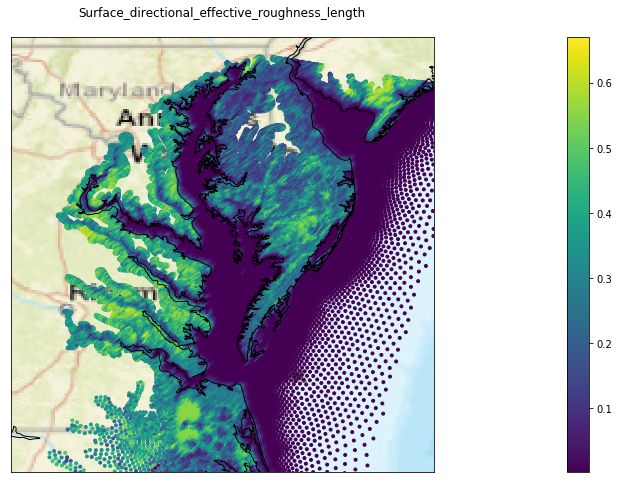

In [16]:
# Plots only one direction of the surface directional roughness
nc = nc4.Dataset(os.path.join(root_dir,'input_fort.nc'),'r')
grp = nc.groups['surface_directional_effective_roughness_length']
lat1,lat2 = 36.2, 39.8
lon1,lon2 = -77.9, -74.4
data = 'NE' # changing this variable to the chosen direction (E,ENE,NE,N,NW,WNW,W,WSW,SW,S,SE,ESE)
pixels=200
title = 'Surface_directional_effective_roughness_length'
fig,ax=plt.subplots(figsize=(48,8))
adcirc.attr_plot(grp,title,ax,lat1,lat2,lon1,lon2,data,pixels)

In [7]:
# Assign date of QC & Name/Info of QC Staff
qc_date = datetime.now()
print('QC Completed on {} by {}, awaiting responses'.format(qc_date, qc_staff))

QC Completed on 2018-08-01 16:36:10.821104 by Tyler Miesse, awaiting responses


## End